In [1]:
import numpy as np
import pandas as pd
import glob
import os  
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import seaborn as sns

from keras import Model
from keras import initializers
from keras.layers import Input
from keras.layers import Dense
from keras.models import load_model
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adagrad, RMSprop, Adadelta, Nadam
from adabound import AdaBound
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from keras.layers.merge import concatenate

from group_norm import GroupNormalization

import matplotlib.pyplot as plt
from PIL import Image, ImageFile

Using TensorFlow backend.


In [2]:
path, dirs, files = next(os.walk(r"C:\\Users\\Tony\\Desktop\\Summer\\boat_classification\\data_aug2"))

In [3]:
class_label = ['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

In [4]:
# Read in the augmented dataset
i = 0

X_data = []
Y_data = []

for boat in class_label:
    files = glob.glob (r"C:\\Users\\Tony\\Desktop\\Summer\\boat_classification\data_aug2\\" + str(boat) + "/*.jpg")
    
    for myFile in files:
      img = Image.open(myFile)
      #img.thumbnail((width, height), Image.ANTIALIAS) # resizes image in-place keeps ratio
      img = img.resize((128,128), Image.ANTIALIAS) # resizes image without ratio
      img = np.array(img)

      if img.shape == (128, 128, 3):
        # Add the numpy image to matrix with all data
        X_data.append (img)
        Y_data.append (i)
        
    i += 1

In [5]:
X = np.array(X_data)
Y = np.array(Y_data)
y_cat = to_categorical(Y_data, len(class_label))
# Normalizing the Data
# y = (x - x.min) / (x.max - x.min)

x_min = X.min(axis=(1, 2), keepdims=True)
x_max = X.max(axis=(1, 2), keepdims=True)
X = (X-x_min) / (x_max-x_min)

In [6]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y_cat, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.2)

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:
# load models from file
all_models = list()
model1 = load_model('./Decay_Models/model_Adam_Decay_40_Epoch_With_35.h5')
model2 = load_model('./Decay_Models/model_Adadelta_Decay1_40Epoch.h5')
model3 = load_model('./Decay_Models/model_Adabound_Decay1_40_Epoch1.h5', custom_objects={'AdaBound': AdaBound})

all_models.append(model1)
all_models.append(model2)
all_models.append(model3)

In [8]:
n_members = 3
weights = [1.0/n_members for _ in range(n_members)]
# make predictions
yhats = [model.predict(X_test) for model in all_models]
yhats = np.array(yhats)
# weighted sum across ensemble members
summed = np.tensordot(yhats, weights, axes=((0),(0)))
result = np.argmax(summed, axis=1)
y_test = y_test.argmax(axis=1)

Incorrect Predictions: 


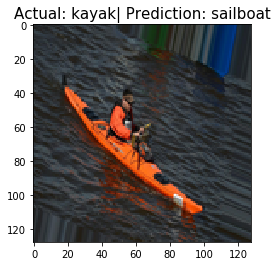

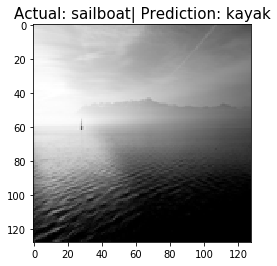

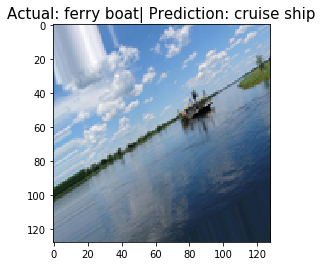

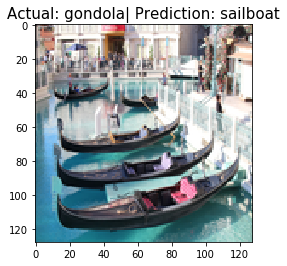

Correct Predictions: 


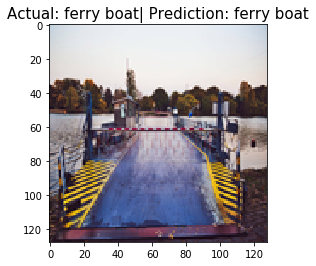

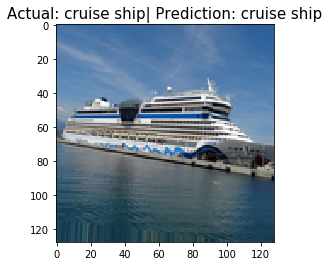

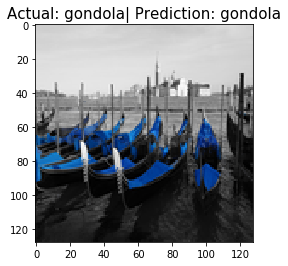

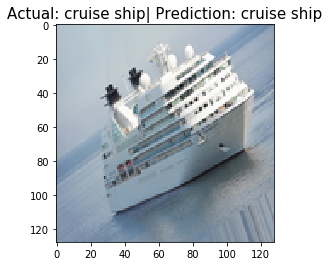

In [12]:
counterC = 1
counterI = 1
i = 0
print('Incorrect Predictions: ')
while counterI < 5:
    actual_label = class_label[y_test[i]]
    predict_label = class_label[result[i]]
    if (actual_label != predict_label):
        plt.imshow((X_test[i]*255))
        plt.title("Actual: " + actual_label + "| Prediction: " + predict_label, fontsize = 15)
        plt.show()
        counterI+=1
        i+=1
    else:
        i+=1
     
print('Correct Predictions: ')
while counterC < 5:
    actual_label = class_label[y_test[i]]
    predict_label = class_label[result[i]]
    if (actual_label == predict_label):
        plt.imshow((X_test[i]*255))
        plt.title("Actual: " + actual_label + "| Prediction: " + predict_label, fontsize = 15)
        plt.show()
        counterC+=1
        i+=1
    else:
        i+=1

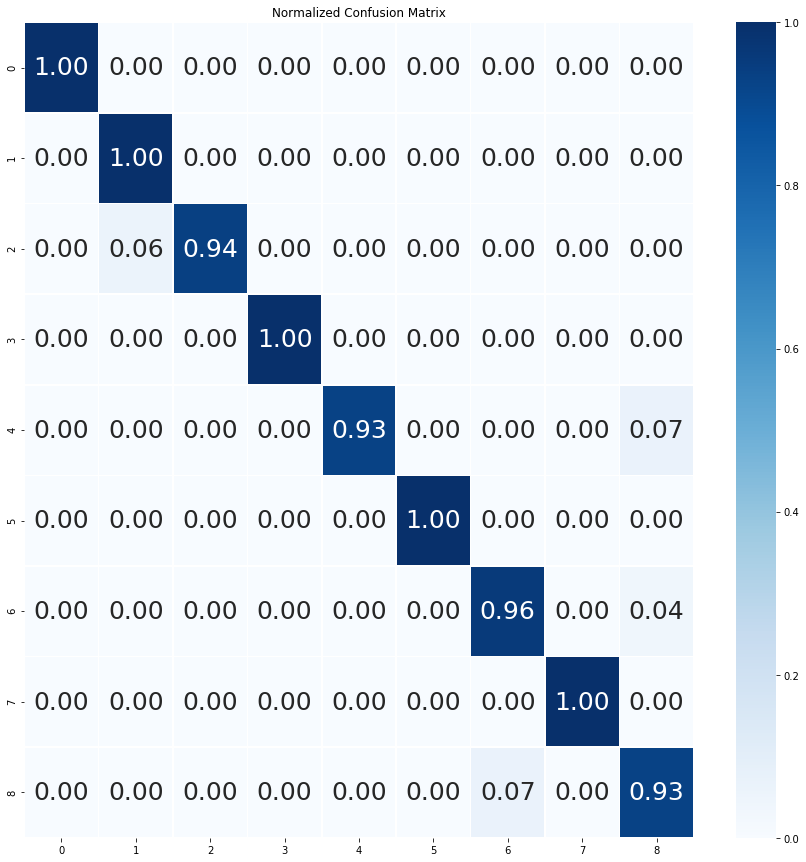

In [13]:
con_matrix = confusion_matrix(y_test, result)
con_matrix = con_matrix / con_matrix.sum(axis=1, keepdims=True)
con_matrix = np.around(con_matrix, 2)
plt.figure(figsize=(15,15))
plt.title('Normalized Confusion Matrix')
sns.heatmap(con_matrix, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", annot_kws={"size": 25})

In [14]:
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.94      1.00      0.97        17
           2       1.00      0.94      0.97        18
           3       1.00      1.00      1.00        15
           4       1.00      0.93      0.96        14
           5       1.00      1.00      1.00        16
           6       0.96      0.96      0.96        24
           7       1.00      1.00      1.00        18
           8       0.88      0.93      0.90        15

    accuracy                           0.97       155
   macro avg       0.98      0.97      0.97       155
weighted avg       0.98      0.97      0.97       155



In [15]:
from sklearn import preprocessing
from scipy import interp
from itertools import cycle

n_classes = len(class_label)
lb = preprocessing.LabelBinarizer()
lb.fit(y_test)
y_true = lb.transform(y_test)
y_pred = lb.transform(result)

lw = 5

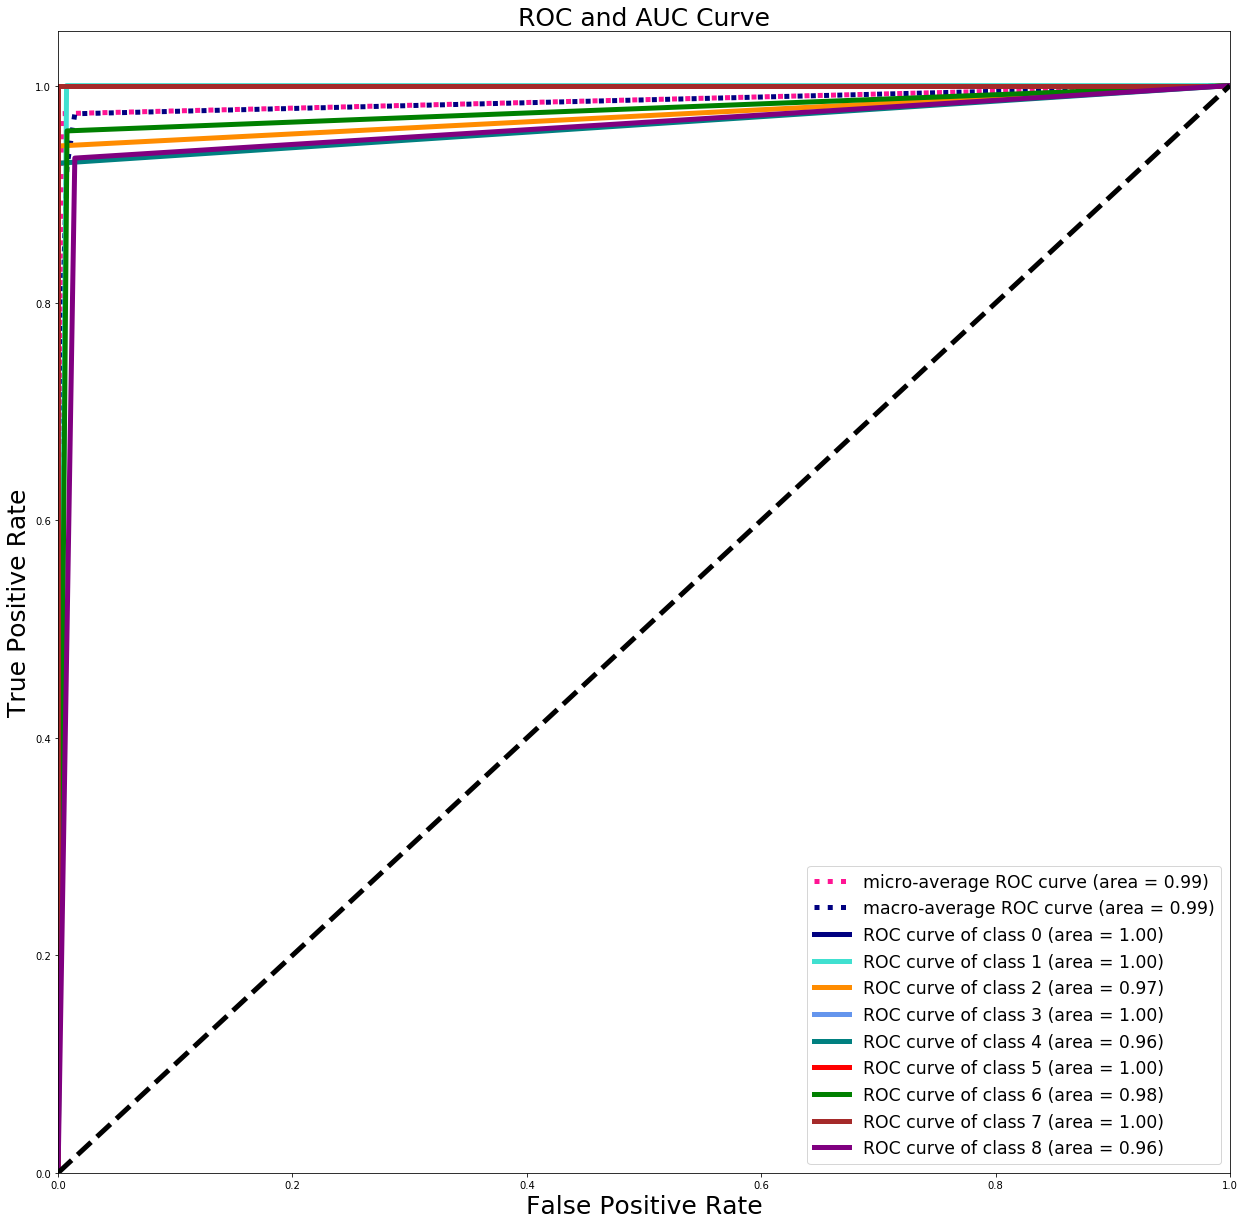

ROC_AUC_Score: 0.9853064922666097


In [16]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
#     # Plot of a ROC curve for a specific class
#     for i in range(n_classes):
#         plt.figure(figsize=(15,15))
#         plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.05])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title('Receiver operating characteristic example')
#         plt.legend(loc="lower right")
#         plt.show()


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(21,21))
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=lw)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'brown', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 25)
    plt.ylabel('True Positive Rate', fontsize = 25)
    plt.title('ROC and AUC Curve', fontsize = 25)
    plt.legend(loc="lower right",fontsize='xx-large')
    plt.show()
        
    return roc_auc_score(y_test, y_pred, average=average)

print("ROC_AUC_Score:", multiclass_roc_auc_score(y_true, y_pred))

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
    
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_true, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.9519


Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.9519')

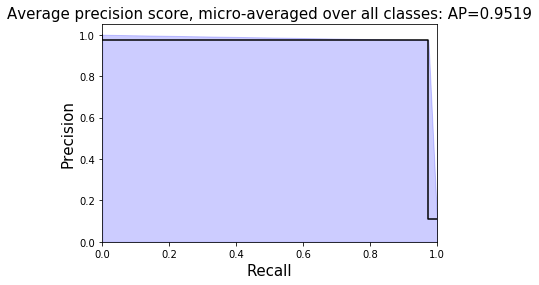

In [18]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='black', alpha=1.0,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='blue')#,
                 #**step_kwargs)

plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.4f}'
    .format(average_precision["micro"]), fontsize = 15)

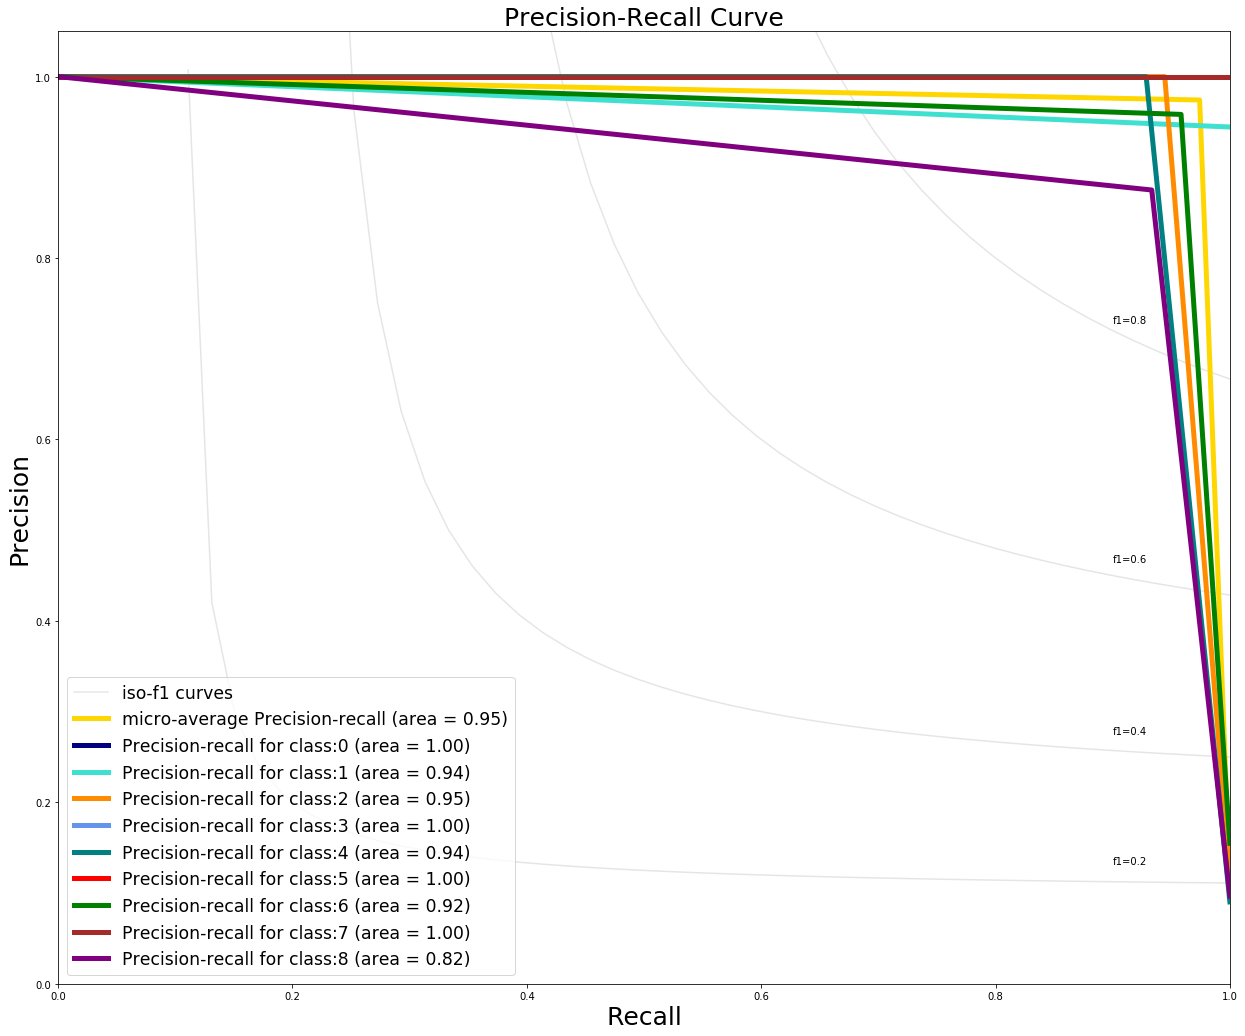

In [19]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'brown', 'purple'])

plt.figure(figsize=(21, 21))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=lw)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize = 25)
plt.ylabel('Precision', fontsize = 25)
plt.title('Precision-Recall Curve', fontsize = 25)
plt.legend(lines, labels, loc='lower left', fontsize='xx-large')


plt.show()